In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt;
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import os as os
import cv2

In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Preparing The Data

### load you data here

In [3]:
#data:
data = np.load('Copy of data_test.npy')
#labels:
labelss = np.load('Copy of labels_test.npy')

In [4]:
nn=data.shape[1]

In [5]:
n=220
data = data.T;
data = data.reshape(nn,300,300,3)

In [6]:
data = tf.keras.layers.Resizing(n, n)(data)

In [7]:
labels = to_categorical(labelss,num_classes=9)

In [8]:
data = np.array(data)

In [9]:
data=data/255

In [10]:
data = tf.data.Dataset.from_tensor_slices((data, labels))

# Loading the weights


In [11]:
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
 
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # You can also use 'val_accuracy' or other metrics
    factor=0.2,           # Factor by which the learning rate will be reduced
    patience=6,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6           # Lower bound on the learning rate
)

# Create the Xception base model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(n, n, 3),
    pooling='avg'
)
base_model.trainable = False
x = Flatten()(base_model.output)
base_model.trainable = True
# Fine-tune only the last few layers
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#base_model.trainable = True

# Fine-tune only the last few layers

x = Dense(300, activation='relu')(x)#, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x=Dropout(0.60)(x)
#x = Dense(100, activation='relu')(x)#, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x=Dropout(0.52)(x)
x = Dense(27, activation='relu')(x)
x=Dropout(0.5)(x)
outputs = Dense(9, activation='softmax')(x)

# Create the full model
xception_model = Model(inputs=base_model.input, outputs=outputs)
xception_model.load_weights('best_weights7.h5')

In [12]:
from tensorflow.keras.optimizers import Nadam
optimizer = Nadam(learning_rate=0.0001, beta_1=0.96, beta_2=0.998)
xception_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Making Predictions

In [13]:
batch_size = 73
loss, accuracy = xception_model.evaluate(data.batch(batch_size))

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

50/50 [==============================] - 63s 1s/step - loss: 0.2202 - accuracy: 0.9646
Test Loss: 0.22018644213676453
Test Accuracy: 0.9646311402320862


In [14]:
predictions_with_labels=[]
for batch in data.batch(batch_size):
    images, labels = batch
    predictions = xception_model.predict(images)

    for i in range(len(predictions)):
        predicted_class = np.argmax(predictions[i])
        max_probability = np.max(predictions[i])
        predictions_with_labels.append(predicted_class)
        

2/2 [==============================] - 1s 358ms/step


In [15]:
labels_names = ['a',
                'b',
                'c',
                'd',
                'e',
                'f',
                'g',
                'h',
                'i']


Class
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       402
         1.0       0.99      0.97      0.98       402
         2.0       0.98      0.98      0.98       401
         3.0       0.96      0.97      0.96       402
         4.0       0.97      0.98      0.98       402
         5.0       0.97      0.98      0.97       402
         6.0       0.92      0.96      0.94       404
         7.0       0.96      0.92      0.94       402
         8.0       0.95      0.96      0.96       402

    accuracy                           0.96      3619
   macro avg       0.96      0.96      0.96      3619
weighted avg       0.96      0.96      0.96      3619



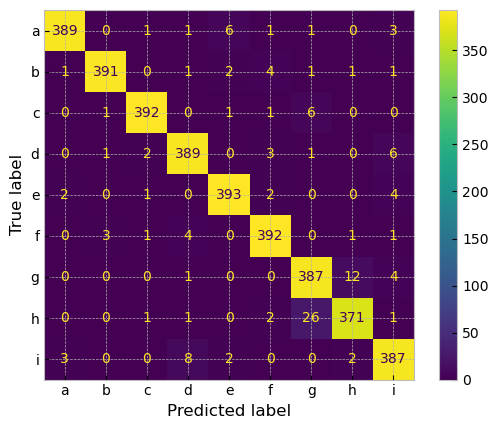

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_train = predictions_with_labels

print('\nClass')
print(classification_report(labelss, y_train))
cm_train=confusion_matrix(labelss, y_train)
disp_train=ConfusionMatrixDisplay(cm_train, display_labels=labels_names)
disp_train.plot(); plt.show()
